In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet("./data/cleaned.parquet")

df

,datetime,usage,temp,stress,load,case_under,case_frame,case_cable,case_gpio,top_solid,top_holed,top_intake,top_exhaust,heatsink_main,heatsink_sub
0,2020-07-30 17:51:07,44.5,46.698,2,NaN,1,1,1,0,1,0,0,0,1,1
1,2020-07-30 17:51:08,49.9,47.236,2,NaN,1,1,1,0,1,0,0,0,1,1
2,2020-07-30 17:51:09,50.0,48.312,2,NaN,1,1,1,0,1,0,0,0,1,1
3,2020-07-30 17:51:10,50.0,48.312,2,NaN,1,1,1,0,1,0,0,0,1,1
4,2020-07-30 17:51:11,50.2,48.850,2,NaN,1,1,1,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61053,2020-07-30 08:54:52,25.0,78.440,1,NaN,1,1,1,1,1,0,0,0,1,1
61054,2020-07-30 08:54:53,25.1,78.440,1,NaN,1,1,1,1,1,0,0,0,1,1
61055,2020-07-30 08:54:54,25.4,77.902,1,NaN,1,1,1,1,1,0,0,0,1,1
61056,2020-07-30 08:54:55,25.0,77.902,1,NaN,1,1,1,1,1,0,0,0,1,1


### Standard OLS

Let's just feed the data to various OLS models. This is a powerful data exploration mechanism since it lets you see the relationship between variables.

If you're not familiar with OLS, it's effectively the same idea as drawing the line of "best fit" through the scatter plots. What OLS also does is show the interactions betwen varialbes while keeping the rest constant. In other words, if a variable has a strong relationship (correlation) with temperature, it will "use up" most of the influence, leaving little for less influential variables. This way, you can spot things that don't seem to affect temperature.

Note: it would seem that `usage` doesn't affect temperature a lot. Yet `usage` is a value that goes from 0 to 100, while all other variables are in the 0 to 1 range. The coefficient for `usage` is actually stronger than it seems.

You may be familiar with OLS from machine learning, but the dashboard below will be new to you. The dashboard provides lots of diagnostic values for the model.

#### Results

As expected, intake and exhaust fans are great for reducing temperatures, with intake fans being more effective. They must do this by pushing air straight onto the CPU.

Interestingly, the case component with the power and HDMI cable helps dissipate a bit more heat than its counterparts. All of these tests were done with a power and an HDMI cable. From other tests I've done, the HDMI does seem to add heat to the computer, so having the case there may spread some of that HDMI heat away from the CPU. **Interesting!**

#### Methods

Below we run three different models. Each uses different levels of interaction for the dummies. For example, `usage:top_solid` means multiply the `top_solid` dummy with `usage`. `usage*top_solid` means we get `usage:top_solid` but also keep the regular `top_solid` too.

In [3]:
dummy_model = smf.ols("temp ~ usage + case_under + case_frame + case_cable + case_gpio + top_solid + top_holed + top_intake + top_exhaust", data=df).fit()

print(dummy_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 4.951e+04
Date:                Wed, 05 Aug 2020   Prob (F-statistic):               0.00
Time:                        08:09:24   Log-Likelihood:            -1.6432e+05
No. Observations:               61058   AIC:                         3.287e+05
Df Residuals:                   61048   BIC:                         3.288e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      65.8071      0.063   1049.222      

In [4]:
interact_model = smf.ols("""temp ~ usage + usage:case_under + usage:case_frame + usage:case_cable + usage:case_gpio
                    + usage:top_solid + usage:top_holed + usage:top_intake + usage:top_exhaust""", data=df).fit()

print(interact_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                 1.018e+04
Date:                Wed, 05 Aug 2020   Prob (F-statistic):               0.00
Time:                        08:09:24   Log-Likelihood:            -2.0095e+05
No. Observations:               61058   AIC:                         4.019e+05
Df Residuals:                   61048   BIC:                         4.020e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            63.4139      0.04

In [5]:
combo_model = smf.ols("""temp ~ usage + usage*case_under + usage*case_frame + usage*case_cable + usage*case_gpio
                    + usage*top_solid + usage*top_holed + usage*top_intake + usage*top_exhaust""", data=df).fit()

print(combo_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                 2.624e+04
Date:                Wed, 05 Aug 2020   Prob (F-statistic):               0.00
Time:                        08:09:24   Log-Likelihood:            -1.6429e+05
No. Observations:               61058   AIC:                         3.286e+05
Df Residuals:                   61040   BIC:                         3.288e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            65.8792      0.10

#### Plots

Even from looking at the results above, we can tell that the `usage:top_solid` interactions were a bust. (I was trying to achieve something that will have to wait until a better dataset.)

Below you can see visually what the model is doing. See how the `usage:top_solid` interactions translate into slopes?

Since the interactions weren't very significant, you can see in the third plot how they don't really have any impact, compared to the first graph without interactions.

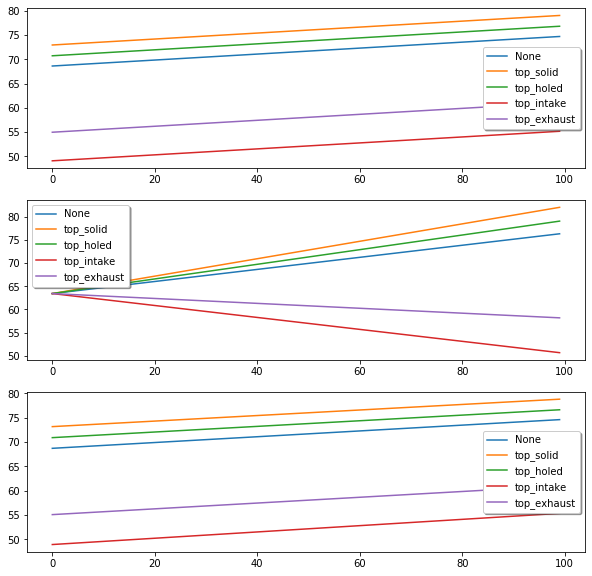

In [6]:
# Let's generate fake data
test = pd.DataFrame({
    "usage":np.arange(100),
    "case_under":1,
    "case_frame":1,
    "case_cable":1,
    "case_gpio":1,
    "top_solid":0,
    "top_holed":0,
    "top_intake":0,
    "top_exhaust":0,
})

fig, axs = plt.subplots(3, 1, figsize=(10,10))
for n, model in enumerate([dummy_model, interact_model, combo_model]):
    axs[n].plot(model.predict(test), label="None")
    for tops in ["top_solid", "top_holed", "top_intake", "top_exhaust"]:
        test_mod = test.copy()
        test_mod[tops] = 1
        axs[n].plot(model.predict(test_mod), label=tops)
    axs[n].legend(loc='best', shadow=True, fancybox=True)
plt.show()

### Time series

To be explained later.

I add lagged variables to look at how various configurations affect how temperature changes over 1-5 seconds.

Unfortunately the data isn't great for this, and it's the `throttle` dummy that clues me into this. The raspberry pi throttles at 60C, so heat should be dissipated more above 60C. However, by looking at the data more closely, I see that some case configurations never go below 60C (closed) and some rarely get close to it (fans). The data we have doesn't give us a complete enough picture of dissipation.

(Even better would be recording CPU frequency. Linux has this in `/proc/cpuinfo`.)

In [7]:
df_dt = df

# Convert the datetime column to a datetime dtype
# This works fine since the datetime is already in a standard format
df_dt["datetime"] = pd.to_datetime(df_dt["datetime"])
df_dt["datetime"] = pd.DatetimeIndex(df_dt["datetime"])

df_dt = df_dt.set_index(df_dt["datetime"])

# Round the datetime to the second
df_dt.index = df_dt.index.round("s")

# Drop the old datetime column
df_dt = df_dt.drop("datetime", axis = 1)

df_dt

,usage,temp,stress,load,case_under,case_frame,case_cable,case_gpio,top_solid,top_holed,top_intake,top_exhaust,heatsink_main,heatsink_sub
datetime,,,,,,,,,,,,,,
2020-07-30 17:51:07,44.5,46.698,2,NaN,1,1,1,0,1,0,0,0,1,1
2020-07-30 17:51:08,49.9,47.236,2,NaN,1,1,1,0,1,0,0,0,1,1
2020-07-30 17:51:09,50.0,48.312,2,NaN,1,1,1,0,1,0,0,0,1,1
2020-07-30 17:51:10,50.0,48.312,2,NaN,1,1,1,0,1,0,0,0,1,1
2020-07-30 17:51:11,50.2,48.850,2,NaN,1,1,1,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-30 08:54:52,25.0,78.440,1,NaN,1,1,1,1,1,0,0,0,1,1
2020-07-30 08:54:53,25.1,78.440,1,NaN,1,1,1,1,1,0,0,0,1,1
2020-07-30 08:54:54,25.4,77.902,1,NaN,1,1,1,1,1,0,0,0,1,1


In [8]:
dt_lag = df_dt

# Create lags
dt_lag["temp_1"] = dt_lag.temp.shift(1, freq="S")
dt_lag["temp_3"] = dt_lag.temp.shift(3, freq="S")
dt_lag["temp_5"] = dt_lag.temp.shift(5, freq="S")
dt_lag["usage_1"] = dt_lag.usage.shift(1, freq="S")
dt_lag["usage_3"] = dt_lag.usage.shift(3, freq="S")
dt_lag["usage_5"] = dt_lag.usage.shift(5, freq="S")

# Create a throtling dummy
# The raspberry pi starts to throttle at 60C
dt_lag["throttle_1"] = [1 if temp >= 60 else 0 for temp in dt_lag.temp_1]
dt_lag["throttle_3"] = [1 if temp >= 60 else 0 for temp in dt_lag.temp_3]
dt_lag["throttle_5"] = [1 if temp >= 60 else 0 for temp in dt_lag.temp_5]

# How nas are there?
dt_lag[dt_lag.isnull().any(axis=1)]

,usage,temp,stress,load,case_under,case_frame,case_cable,case_gpio,top_solid,top_holed,...,heatsink_sub,temp_1,temp_3,temp_5,usage_1,usage_3,usage_5,throttle_1,throttle_3,throttle_5
datetime,,,,,,,,,,,,,,,,,,,,,
2020-07-30 17:51:07,44.5,46.698,2,NaN,1,1,1,0,1,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2020-07-30 17:51:08,49.9,47.236,2,NaN,1,1,1,0,1,0,...,1,46.698,NaN,NaN,44.5,NaN,NaN,0,0,0
2020-07-30 17:51:09,50.0,48.312,2,NaN,1,1,1,0,1,0,...,1,47.236,NaN,NaN,49.9,NaN,NaN,0,0,0
2020-07-30 17:51:10,50.0,48.312,2,NaN,1,1,1,0,1,0,...,1,48.312,46.698,NaN,50.0,44.5,NaN,0,0,0
2020-07-30 17:51:11,50.2,48.850,2,NaN,1,1,1,0,1,0,...,1,48.312,47.236,NaN,50.0,49.9,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-30 08:54:52,25.0,78.440,1,NaN,1,1,1,1,1,0,...,1,78.440,78.440,78.978,25.0,25.2,25.0,1,1,1
2020-07-30 08:54:53,25.1,78.440,1,NaN,1,1,1,1,1,0,...,1,78.440,78.978,78.440,25.0,25.0,25.1,1,1,1
2020-07-30 08:54:54,25.4,77.902,1,NaN,1,1,1,1,1,0,...,1,78.440,78.440,78.440,25.1,25.0,25.2,1,1,1


In [9]:
# TEMP
dt_lag = dt_lag.drop("load", axis=1)

dt_lag = dt_lag.dropna()

dt_lag

,usage,temp,stress,case_under,case_frame,case_cable,case_gpio,top_solid,top_holed,top_intake,...,heatsink_sub,temp_1,temp_3,temp_5,usage_1,usage_3,usage_5,throttle_1,throttle_3,throttle_5
datetime,,,,,,,,,,,,,,,,,,,,,
2020-07-30 17:51:12,49.4,49.388,2,1,1,1,0,1,0,0,...,1,48.850,48.312,46.698,50.2,50.0,44.5,0,0,0
2020-07-30 17:51:13,0.2,47.774,0,1,1,1,0,1,0,0,...,1,49.388,48.312,47.236,49.4,50.0,49.9,0,0,0
2020-07-30 17:51:14,0.0,47.236,0,1,1,1,0,1,0,0,...,1,47.774,48.850,48.312,0.2,50.2,50.0,0,0,0
2020-07-30 17:51:15,0.3,46.160,0,1,1,1,0,1,0,0,...,1,47.236,49.388,48.312,0.0,49.4,50.0,0,0,0
2020-07-30 17:51:16,74.3,49.388,3,1,1,1,0,1,0,0,...,1,46.160,47.774,48.850,0.3,0.2,50.2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-30 08:54:52,25.0,78.440,1,1,1,1,1,1,0,0,...,1,78.440,78.440,78.978,25.0,25.2,25.0,1,1,1
2020-07-30 08:54:53,25.1,78.440,1,1,1,1,1,1,0,0,...,1,78.440,78.978,78.440,25.0,25.0,25.1,1,1,1
2020-07-30 08:54:54,25.4,77.902,1,1,1,1,1,1,0,0,...,1,78.440,78.440,78.440,25.1,25.0,25.2,1,1,1


In [10]:
results = smf.ols("""temp ~ usage_1 + usage_3 + usage_5
                  + temp_1 + temp_3 + temp_5
                  + throttle_1 + throttle_3 + throttle_5""", data=dt_lag).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.571e+06
Date:                Wed, 05 Aug 2020   Prob (F-statistic):               0.00
Time:                        08:09:26   Log-Likelihood:                -61559.
No. Observations:               60447   AIC:                         1.231e+05
Df Residuals:                   60437   BIC:                         1.232e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3162      0.031     10.249      0.0

In [11]:
lag_1 = smf.ols("""temp ~ usage_3 + temp_3 + throttle_3
                + case_under + case_frame + case_cable + case_gpio
                + top_solid + top_holed + top_intake + top_exhaust""", data=dt_lag).fit()

print(lag_1.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 2.558e+05
Date:                Wed, 05 Aug 2020   Prob (F-statistic):               0.00
Time:                        08:09:26   Log-Likelihood:            -1.0985e+05
No. Observations:               60447   AIC:                         2.197e+05
Df Residuals:                   60435   BIC:                         2.198e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.3054      0.118     61.747      

In [12]:
lag_1_interact = smf.ols("""temp ~ usage_3 + temp_3 + throttle_3
                            + temp_3:case_cable + temp_3:case_gpio
                            + temp_3:top_solid + temp_3:top_holed + temp_3:top_intake + temp_3:top_exhaust""",
                         data=dt_lag.loc[(dt_lag.top_intake == 1) | (dt_lag.top_exhaust == 1)]).fit()

print(lag_1_interact.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                 3.112e+04
Date:                Wed, 05 Aug 2020   Prob (F-statistic):               0.00
Time:                        08:09:26   Log-Likelihood:                -38600.
No. Observations:               21303   AIC:                         7.722e+04
Df Residuals:                   21295   BIC:                         7.728e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.3638      0

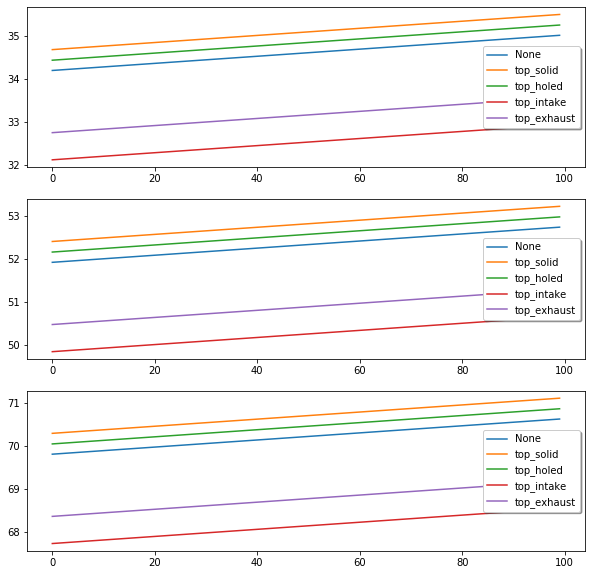

In [13]:
# Let's generate fake data
test = pd.DataFrame({
    "usage_3":np.arange(100),
    "temp_3":30,
    "throttle_3":0,
    "case_under":1,
    "case_frame":1,
    "case_cable":1,
    "case_gpio":1,
    "top_solid":0,
    "top_holed":0,
    "top_intake":0,
    "top_exhaust":0,
})

fig, axs = plt.subplots(3, 1, figsize=(10,10))
for n, (temp, throttle) in enumerate(zip([30, 50, 70], [0, 0, 1])):
    test_temp = test.copy()
    test_temp["temp_3"] = temp
    test_temp["throttle_3"] = throttle
    axs[n].plot(lag_1.predict(test_temp), label="None")
    for tops in ["top_solid", "top_holed", "top_intake", "top_exhaust"]:
        test_mod = test_temp.copy()
        test_mod[tops] = 1
        axs[n].plot(lag_1.predict(test_mod), label=tops)
    axs[n].legend(loc='best', shadow=True, fancybox=True)
plt.show()